
# Bài 2: Tóm tắt máy biến áp

Chào mừng bạn đến với bài tập thứ hai của khóa học 4. Trong bài tập này, bạn sẽ khám phá cách tóm tắt bằng mô hình máy biến áp. Có, bạn sẽ triển khai bộ giải mã máy biến áp từ đầu, nhưng chúng tôi sẽ hướng dẫn bạn dần dần về nó. Có rất nhiều gợi ý trong cuốn sổ này nên bạn có thể thoải mái sử dụng chúng khi cần thiết. Trên thực tế, đến cuối cuốn sổ này, bạn sẽ triển khai bộ biến áp đầy đủ (cả bộ mã hóa và bộ giải mã) nhưng bạn sẽ chỉ được chấm điểm khi triển khai bộ giải mã vì bộ mã hóa được cung cấp cho bạn.


## Mục lục

- [Introduction](#0)
- [1 - Importing the Dataset](#1)
- [2 - Preprocess the Data](#2)
- [3 - Positional Encoding](#3)
- [4 - Masking](#4)
- [5 - Self-attention](#5)
- [Exercise 1 - scaled_dot_product_attention](#ex-1)
- [6 - Encoder](#6)
- [6.1 - Encoder Layer](#6-1)
- [6.2 - Full Encoder](#6-2)
- [7 - Decoder](#7)
- [7.1 - Decoder Layer](#7-1)
- [Exercise 2 - DecoderLayer](#ex-2)
- [7.2 - Full Decoder](#7-2)
- [Exercise 3 - Decoder](#ex-3)
- [8 - Transformer](#8)
- [Exercise 4 - Transformer](#ex-4)
- [9 - Initialize the Model](#9)
- [10 - Prepare for Training the Model](#10)
- [11 - Summarization](#11)
- [Exercise 5 - next_word](#ex-5)
- [12 - Train the Model](#12)
- [13 - Summarize some sentences!](#13)


<a name='0'></a>
## Giới thiệu

Tóm tắt là một nhiệm vụ quan trọng trong xử lý ngôn ngữ tự nhiên và có thể hữu ích cho doanh nghiệp tiêu dùng. Ví dụ: bot có thể được sử dụng để thu thập các bài viết, tóm tắt chúng và sau đó bạn có thể sử dụng phân tích tâm lý để xác định tâm lý về một số cổ phiếu nhất định. Hôm nay ai lại muốn đọc một bài báo hay một email dài khi bạn có thể xây dựng một máy biến áp để tóm tắt văn bản cho mình? Bắt đầu nào. Khi hoàn thành nhiệm vụ này, bạn sẽ học được:

- Sử dụng các chức năng tích hợp để xử lý trước dữ liệu của bạn
- Triển khai DotProductAttention
- Thực hiện chú ý nhân quả
- Hiểu cách thức hoạt động của sự chú ý
- Xây dựng mô hình máy biến áp
- Đánh giá mô hình của bạn
- Tóm tắt một bài viết

Như bạn có thể thấy, mô hình này hơi khác so với những mô hình bạn đã triển khai. Điều này chủ yếu dựa vào sự chú ý và không dựa vào trình tự, cho phép tính toán song song.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import utils

import textwrap
wrapper = textwrap.TextWrapper(width=70)

tf.keras.utils.set_random_seed(10)

In [2]:
import w2_unittest

<a name='1'></a>
##1 - Nhập Dataset
Bạn có tập dữ liệu được lưu trong tệp .json mà bạn có thể dễ dàng mở bằng gấu trúc. Chức năng tải đã được xử lý trong `utils.py`.

In [3]:
data_dir = "data/corpus"

train_data, test_data = utils.get_train_test_data(data_dir)

# Take one example from the dataset and print it
example_summary, example_dialogue = train_data.iloc[10]
print(f"Dialogue:\n{example_dialogue}")
print(f"\nSummary:\n{example_summary}")

Dialogue:
Lucas: Hey! How was your day?
Demi: Hey there! 
Demi: It was pretty fine, actually, thank you!
Demi: I just got promoted! :D
Lucas: Whoa! Great news!
Lucas: Congratulations!
Lucas: Such a success has to be celebrated.
Demi: I agree! :D
Demi: Tonight at Death & Co.?
Lucas: Sure!
Lucas: See you there at 10pm?
Demi: Yeah! See you there! :D

Summary:
Demi got promoted. She will celebrate that with Lucas at Death & Co at 10 pm.


<a name='2'></a>
##2 - Xử lý trước dữ liệu

Trước tiên, bạn sẽ thực hiện một số bước tiền xử lý dữ liệu và chia nó thành đầu vào và đầu ra. Tại đây, bạn cũng xóa một số ký tự dành riêng cho tập dữ liệu này và thêm mã thông báo `[EOS]` (end of sentence) vào cuối, giống như đã được thảo luận trong các video bài giảng. Bạn cũng sẽ thêm mã thông báo `[EOS]` (end of sentence) vào đầu câu.

In [4]:
document, summary = utils.preprocess(train_data)
document_test, summary_test = utils.preprocess(test_data)

Bây giờ hãy thực hiện quá trình tiền xử lý tiêu chuẩn với thư viện tensorflow. Bạn sẽ cần sửa đổi các bộ lọc vì bạn không muốn xóa mã thông báo `[EOS]`.

Sau đó tạo từ vựng bằng cách kết hợp dữ liệu trong tài liệu và phần tóm tắt rồi sử dụng `.fit_on_texts()`:

In [5]:
# The [ and ] from default tokens cannot be removed, because they mark the SOS and EOS token.
filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n'
oov_token = '[UNK]'

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token, lower=False)

documents_and_summary = pd.concat([document, summary], ignore_index=True)

tokenizer.fit_on_texts(documents_and_summary)

inputs = tokenizer.texts_to_sequences(document)
targets = tokenizer.texts_to_sequences(summary)

vocab_size = len(tokenizer.word_index) + 1

print(f'Size of vocabulary: {vocab_size}')

Size of vocabulary: 34250


Bây giờ bạn có thể đệm các chuỗi được mã hóa cho dữ liệu huấn luyện.

Vì mục đích của cuốn sổ tay này, bạn cần giới hạn độ dài của các trình tự, vì máy biến áp thực sự là những mô hình lớn và không được đào tạo trong những môi trường nhỏ như vậy.

In [6]:
# Limit the size of the input and output data for being able to run it in this environment.
encoder_maxlen = 150
decoder_maxlen = 50

# Pad the sequences.
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

# Create the final training dataset.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<a name='3'></a>
## 3 - Mã hóa vị trí

Theo trình tự các nhiệm vụ, thứ tự tương đối của dữ liệu của bạn là cực kỳ quan trọng đối với ý nghĩa của nó. Khi bạn đào tạo các mạng thần kinh tuần tự như RNN, bạn đã đưa đầu vào của mình vào mạng theo thứ tự. Thông tin về thứ tự dữ liệu của bạn đã được tự động đưa vào mô hình của bạn. Tuy nhiên, khi bạn huấn luyện mạng Transformer bằng cách sử dụng sự chú ý của nhiều đầu, bạn sẽ đưa tất cả dữ liệu của mình vào mô hình cùng một lúc. Mặc dù điều này làm giảm đáng kể thời gian đào tạo nhưng không có thông tin nào về thứ tự dữ liệu của bạn. Đây là nơi mã hóa vị trí hữu ích.

Bạn đã học cách triển khai mã hóa vị trí ở một trong các phòng thí nghiệm của tuần này. Tại đây, bạn sẽ sử dụng hàm `positional_encoding` để tạo mã hóa vị trí cho máy biến áp của mình. Chức năng này đã được triển khai cho bạn.

In [7]:
def positional_encoding(positions, d_model):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int): Maximum number of positions to be encoded 
        d_model (int): Encoding size 
    
    Returns:
        pos_encoding (tf.Tensor): A matrix of shape (1, position, d_model) with the positional encodings
    """
    
    position = np.arange(positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2
    
    # initialize a matrix angle_rads of all the angles 
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

<a name='4'></a>
##4 - Đắp mặt nạ

Có hai loại mặt nạ hữu ích khi xây dựng mạng Transformer của bạn: *mặt nạ đệm* và *mặt nạ nhìn về phía trước*. Cả hai đều giúp tính toán softmax đưa ra trọng số thích hợp cho các từ trong câu đầu vào của bạn.

Bạn đã học cách triển khai và sử dụng chúng ở một trong các phòng thí nghiệm của tuần này. Ở đây chúng được thực hiện cho bạn.

In [8]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids (matrix like): matrix of size (n, m)
    
    Returns:
        mask (tf.Tensor): binary tensor of size (n, 1, m)
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding to the attention logits. 
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :] 


def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length (int): matrix size
    
    Returns:
        mask (tf.Tensor): binary tensor of size (sequence_length, sequence_length)
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

<a name='5'></a>
##5 - Tự Chú Ý

Như tác giả của bài báo về Transformers đã tuyên bố, "Tất cả những gì bạn cần là sự chú ý".

<img src="images/self-attention.png" alt="Encoder" width="600"/>
<caption><center><font color='purple'><b>Hình 1: Trực quan hóa phép tính Tự chú ý</font></center></caption>

Việc sử dụng tính năng tự chú ý kết hợp với mạng tích chập truyền thống cho phép thực hiện song song giúp tăng tốc quá trình đào tạo. Bạn sẽ triển khai **chú ý đến sản phẩm chấm theo tỷ lệ** lấy truy vấn, khóa, giá trị và mặt nạ làm đầu vào để trả về các biểu diễn vectơ phong phú, dựa trên sự chú ý của các từ trong chuỗi của bạn. Kiểu tự chú ý này có thể được biểu diễn bằng toán học như sau:
$$
\text { Chú ý }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag {4}\
$$

* $Q$ là ma trận truy vấn
* $K$ là ma trận các khóa
* $V$ là ma trận các giá trị
* $M$ là mặt nạ tùy chọn bạn chọn để áp dụng
* ${d_k}$ là kích thước của các phím, được sử dụng để thu nhỏ mọi thứ để softmax không bị nổ

<a name='ex-1'></a>
### Bài tập 1 -scaled_dot_product_attention

Triển khai hàm `scaled_dot_product_attention()` để tạo các biểu diễn dựa trên sự chú ý.

**Lời nhắc**: Tham số mặt nạ boolean có thể được chuyển vào dưới dạng `none` hoặc dưới dạng đệm hoặc nhìn về phía trước.

* Nhân (1. - mặt nạ) với -1e9 trước khi thêm nó vào nhật ký chú ý được chia tỷ lệ.

**Gợi ý bổ sung**
* Bạn có thể thấy [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) hữu ích cho phép nhân ma trận (kiểm tra cách bạn có thể sử dụng tham số transpose_b).
* Bạn có thể sử dụng [tf.keras.activations.softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) cho softmax.

In [17]:
# GRADED FUNCTION: scaled_dot_product_attention
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q (tf.Tensor): query of shape (..., seq_len_q, depth)
        k (tf.Tensor): key of shape (..., seq_len_k, depth)
        v (tf.Tensor): value of shape (..., seq_len_v, depth_v)
        mask (tf.Tensor): mask with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    ### START CODE HERE ###
    
    # Multiply q and k transposed.
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk with the square root of dk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:  # Don't replace this None
        scaled_attention_logits += (1 - mask) * -1e9

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Multiply the attention weights by v
    output = tf.matmul(attention_weights, v)
    
    ### END CODE HERE ###

    return output, attention_weights

In [18]:
# Test your function!
q = np.array([[1, 1, 0, 1], [0, 1, 1, 1], [1, 0, 1, 1]]).astype(np.float32)
k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [1, 1, 1, 0], [0, 0, 0, 1], [0, 1, 0, 1]]).astype(np.float32)
v = np.array([[0, 0], [1, 0], [1, 0], [1, 1], [1, 1]]).astype(np.float32)
mask = np.array([[[0, 1, 0, 1, 1], [1, 0, 0, 1, 1], [1, 1, 0, 1, 1]]])

ou, atw = scaled_dot_product_attention(q, k, v, mask)
ou = np.around(ou, decimals=2)
atw = np.around(atw, decimals=2)

print(f"Output:\n {ou}")
print(f"\nAttention weigths:\n {atw}")

Output:
 [[[1.   0.62]
  [0.62 0.62]
  [0.74 0.31]]]

Attention weigths:
 [[[0.   0.38 0.   0.23 0.38]
  [0.38 0.   0.   0.23 0.38]
  [0.26 0.43 0.   0.16 0.16]]]


##### __Kết quả mong đợi__

```
Output:
 [[[1.   0.62]
  [0.62 0.62]
  [0.74 0.31]]]

Attention weigths:
 [[[0.   0.38 0.   0.23 0.38]
  [0.38 0.   0.   0.23 0.38]
  [0.26 0.43 0.   0.16 0.16]]]
```

In [19]:
# UNIT TEST
w2_unittest.test_scaled_dot_product_attention(scaled_dot_product_attention)

 All tests passed!


Công việc tuyệt vời! Bây giờ bạn có thể thực hiện việc tự chú ý. Với điều đó, bạn có thể bắt đầu xây dựng khối mã hóa!

<a name='6'></a>
## 6 - Bộ mã hóa

Lớp Bộ mã hóa biến áp kết hợp kiểu xử lý mạng thần kinh tích chập và tự chú ý để cải thiện tốc độ huấn luyện và chuyển ma trận K và V cho Bộ giải mã mà bạn sẽ xây dựng sau trong bài tập. Trong phần bài tập này, bạn sẽ triển khai Bộ mã hóa bằng cách ghép nối sự chú ý nhiều đầu và mạng nơ-ron chuyển tiếp nguồn cấp dữ liệu (Hình 2a).
<img src="images/encoder_layer.png" alt="Encoder" width="400"/>
<caption><center><font color='purple'><b>Hình 2a: Lớp mã hóa máy biến áp</font></center></caption>

* `MultiHeadAttention` bạn có thể coi là tính toán tự chú ý nhiều lần để phát hiện các tính năng khác nhau.
* Mạng nơ-ron chuyển tiếp nguồn cấp dữ liệu chứa hai lớp dày đặc mà chúng tôi sẽ triển khai dưới dạng chức năng `FullyConnected`

Trước tiên, câu đầu vào của bạn sẽ đi qua *lớp chú ý nhiều đầu*, trong đó bộ mã hóa xem xét các từ khác trong câu đầu vào khi mã hóa một từ cụ thể. Sau đó, đầu ra của lớp chú ý nhiều đầu được đưa đến *mạng thần kinh chuyển tiếp nguồn cấp dữ liệu*. Mạng chuyển tiếp nguồn cấp dữ liệu giống hệt nhau được áp dụng độc lập cho từng vị trí.

* Đối với lớp `MultiHeadAttention`, bạn sẽ sử dụng [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) được triển khai trong Keras. Nếu bạn tò mò về cách chia ma trận truy vấn Q, ma trận khóa K và ma trận giá trị V thành các phần đầu khác nhau, bạn có thể xem qua phần triển khai.
* Bạn cũng sẽ sử dụng [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) với hai lớp dày đặc để xây dựng các lớp mạng thần kinh chuyển tiếp nguồn cấp dữ liệu.

In [20]:
def FullyConnected(embedding_dim, fully_connected_dim):
    """
    Returns a sequential model consisting of two dense layers. The first dense layer has
    fully_connected_dim neurons and is activated by relu. The second dense layer has
    embedding_dim and no activation.

    Arguments:
        embedding_dim (int): output dimension
        fully_connected_dim (int): dimension of the hidden layer

    Returns:
        _ (tf.keras.Model): sequential model
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, d_model)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

<a name='6-1'></a>
### 6.1 Lớp mã hóa

Giờ đây, bạn có thể ghép nối sự chú ý của nhiều đầu và chuyển tiếp mạng nơ-ron với nhau trong một lớp mã hóa! Bạn cũng sẽ sử dụng các kết nối còn lại và chuẩn hóa lớp để giúp tăng tốc độ đào tạo (Hình 2a).

Khối bộ mã hóa (Hình 2) đã được triển khai cho bạn. Hãy xem xét kỹ cách triển khai nó, vì sau này bạn sẽ phải tự tạo bộ giải mã và rất nhiều mã rất giống nhau. Khối mã hóa thực hiện các bước sau:
1. Nó đưa các ma trận Q, V, K và mặt nạ boolean vào lớp chú ý nhiều đầu. Hãy nhớ rằng để tính toán *tự*-chú ý Q, V và K đều giống nhau. Bạn cũng sẽ thực hiện Dropout trong lớp chú ý nhiều đầu này trong quá trình đào tạo.
2. Có một kết nối bỏ qua để thêm đầu vào `x` ban đầu của bạn và đầu ra của lớp chú ý nhiều đầu.
3. Sau khi thêm kết nối bỏ qua, đầu ra sẽ đi qua lớp chuẩn hóa đầu tiên.
4. Cuối cùng, các bước 1-3 được lặp lại nhưng với mạng nơ-ron chuyển tiếp nguồn cấp dữ liệu có lớp bỏ học thay vì lớp chú ý nhiều đầu.

<chi tiết>
<summary><font size="2" color="darkgreen"><b>Thông tin bổ sung (Nhấp để mở rộng)</b></font></summary>

* Phương thức `__init__` tạo tất cả các lớp sẽ được truy cập bằng phương thức `call`. Bất cứ nơi nào bạn muốn sử dụng một lớp được xác định bên trong phương thức `__init__`, bạn sẽ phải sử dụng cú pháp `self.[insert layer name]`.
* Bạn sẽ thấy tài liệu về [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) hữu ích. *Lưu ý rằng nếu truy vấn, khóa và giá trị giống nhau thì hàm này sẽ thực hiện tự chú ý.*
* Các đối số lệnh gọi cho `self.mha` là (Trong đó B dành cho batch_size, T dành cho hình dạng chuỗi mục tiêu và S là out_shape):
- `query`: Tensor truy vấn có hình dạng (B, T, dim).
- `value`: Giá trị Tensor của hình dạng (B, S, dim).
- `key`: Phím tùy chọn Tensor hình dạng (B, S, dim). Nếu không được cung cấp, sẽ sử dụng cùng một giá trị cho cả khóa và giá trị, đây là trường hợp phổ biến nhất.
- `attention_mask`: một mặt nạ boolean có hình dạng (B, T, S), ngăn sự chú ý đến các vị trí nhất định. Mặt nạ boolean chỉ định thành phần truy vấn nào có thể tham gia vào thành phần chính nào, 1 biểu thị sự chú ý và 0 biểu thị không chú ý. Việc phát sóng có thể xảy ra đối với các kích thước lô bị thiếu và kích thước phần đầu.
- `return_attention_scores`: Một boolean để cho biết liệu đầu ra có phải là đầu ra chú ý nếu Đúng hay (attention_output, chú ý_scores) nếu Sai. Mặc định là Sai.
- `training`: Python boolean cho biết lớp sẽ hoạt động ở chế độ huấn luyện (thêm bỏ học) hay ở chế độ suy luận (không bỏ học). Mặc định là sử dụng chế độ đào tạo của lớp/mô hình cha hoặc Sai (suy luận) nếu không có lớp cha. Hãy xem [tf.keras.layers.Dropout](https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/Dropout) để biết thêm chi tiết (Đọc thêm trong [tf.keras.layers.Dropout](https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/Dropout))

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This architecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        
        super(EncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(x, x, x, mask)  # Self attention (batch_size, input_seq_len, fully_connected_dim)
        
        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer
        skip_x_attention = self.layernorm1(x + self_mha_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # pass the output of the multi-head attention layer through a ffn
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, fully_connected_dim)
        
        # apply dropout layer to ffn output during training
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output
        # to get the output of the encoder layer
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)
        
        return encoder_layer_out
    

<a name='6-2'></a>
### 6.2 - Bộ mã hóa đầy đủ

Bây giờ bạn đã sẵn sàng xây dựng Bộ mã hóa biến áp đầy đủ (Hình 2b), nơi bạn sẽ nhúng đầu vào của mình và thêm các mã hóa vị trí mà bạn đã tính toán. Sau đó, bạn sẽ cung cấp các phần nhúng được mã hóa của mình vào một chồng các lớp Bộ mã hóa.

<img src="images/encoder.png" alt="Encoder" width="330"/>
<caption><center><font color='purple'><b>Hình 2b: Bộ mã hóa máy biến áp</font></center></caption>

Lớp Bộ mã hóa được triển khai cho bạn. Nó thực hiện các bước sau:
1. Truyền đầu vào qua lớp Nhúng.
2. Chia tỷ lệ phần nhúng bằng cách nhân nó với căn bậc hai của kích thước phần nhúng.
3. Thêm mã hóa vị trí: self.pos_encoding `[:, :seq_len, :]` vào phần nhúng.
4. Truyền phần nhúng được mã hóa qua lớp bỏ học
5. Truyền đầu ra của lớp bỏ học qua ngăn xếp các lớp mã hóa bằng vòng lặp for.

In [23]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input

        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]
        
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, embedding_dim)

<a name='7'></a>
##7 - Bộ giải mã

Bây giờ là lúc triển khai bộ giải mã. Bạn đã thấy nó trong video và bạn có thể sử dụng một số trợ giúp bằng cách xem cách triển khai bộ mã hóa ở trên. Lớp Bộ giải mã lấy ma trận K và V do Bộ mã hóa tạo ra và tính toán lớp chú ý nhiều đầu thứ hai với ma trận Q từ đầu ra (Hình 3a).

<img src="images/decoder_layer.png" alt="Decoder" width="250"/>
<caption><center><font color='purple'><b>Hình 3a: Lớp Transformer Decoding</font></center></caption>

<a name='7-1'></a>
### 7.1 - Lớp giải mã
Một lần nữa, bạn sẽ ghép nối sự chú ý nhiều đầu với mạng nơ-ron chuyển tiếp nguồn cấp dữ liệu, nhưng lần này bạn sẽ triển khai hai lớp chú ý nhiều đầu. Bạn cũng sẽ sử dụng các kết nối còn lại và chuẩn hóa lớp để giúp tăng tốc độ đào tạo (Hình 3a).

<a name='ex-2'></a>
### Bài tập 2 - DecodeLayer

Triển khai `DecodeLayer()` bằng phương thức `call()`

1. Khối 1 là lớp chú ý nhiều đầu với kết nối còn lại và mặt nạ nhìn về phía trước. Giống như trong `EncodeLayer`, Dropout được xác định trong lớp chú ý nhiều đầu.
2. Khối 2 sẽ tính đến đầu ra của Bộ mã hóa, do đó lớp chú ý nhiều đầu sẽ nhận K và V từ bộ mã hóa và Q từ Khối 1. Sau đó, bạn sẽ áp dụng lớp chuẩn hóa và kết nối dư, chỉ cần giống như bạn đã làm trước đây với `EncodeLayer`.
3. Cuối cùng, Khối 3 là mạng nơ-ron chuyển tiếp nguồn cấp dữ liệu với các lớp loại bỏ và chuẩn hóa cũng như kết nối còn lại.

**Gợi ý bổ sung:**
* Hai khối đầu tiên khá giống với EncodingLayer ngoại trừ bạn sẽ trả về `attention_scores` khi tính toán self-attention

In [28]:
import tensorflow as tf

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.mha2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # First dense layer
            tf.keras.layers.Dense(embedding_dim)  # Second dense layer
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # Block 1: Self-attention
        attn1, attn_weights_block1 = self.mha1(x, x, x, attention_mask=look_ahead_mask, return_attention_scores=True, training=training)
        out1 = self.layernorm1(x + attn1)  # Apply residual connection followed by layer normalization
        
        # Block 2: Attention over encoder output
        attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output, attention_mask=padding_mask, return_attention_scores=True, training=training)
        out2 = self.layernorm2(out1 + attn2)  # Apply residual connection followed by layer normalization
        
        # Block 3: Fully connected feed-forward network
        ffn_output = self.ffn(out2)  # Pass through feed forward network
        ffn_output = self.dropout_ffn(ffn_output, training=training)  # Apply dropout
        out3 = self.layernorm3(out2 + ffn_output)  # Apply residual connection followed by layer normalization

        return out3, attn_weights_block1, attn_weights_block2


In [29]:
# Test your function!
key_dim = 12
n_heads = 16

decoderLayer_test = DecoderLayer(embedding_dim=key_dim, num_heads=n_heads, fully_connected_dim=32)

q = np.ones((1, 15, key_dim))
encoder_test_output = tf.convert_to_tensor(np.random.rand(1, 7, 8))
look_ahead_mask = create_look_ahead_mask(q.shape[1])

out, attn_w_b1, attn_w_b2 = decoderLayer_test(q, encoder_test_output, False, look_ahead_mask, None)

print(f"Using embedding_dim={key_dim} and num_heads={n_heads}:\n")
print(f"q has shape:{q.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder layer has shape:{out.shape}")
print(f"Att Weights Block 1 has shape:{attn_w_b1.shape}")
print(f"Att Weights Block 2 has shape:{attn_w_b2.shape}")

Using embedding_dim=12 and num_heads=16:

q has shape:(1, 15, 12)
Output of encoder has shape:(1, 7, 8)

Output of decoder layer has shape:(1, 15, 12)
Att Weights Block 1 has shape:(1, 16, 15, 15)
Att Weights Block 2 has shape:(1, 16, 15, 7)


##### __Kết quả mong đợi__

```
Output:
Using embedding_dim=12 and num_heads=16:

q has shape:(1, 15, 12)
Output of encoder has shape:(1, 7, 8)

Output of decoder layer has shape:(1, 15, 12)
Att Weights Block 1 has shape:(1, 16, 15, 15)
Att Weights Block 2 has shape:(1, 16, 15, 7)
```

In [30]:
# UNIT TEST
w2_unittest.test_decoderlayer(DecoderLayer, create_look_ahead_mask)

 All tests passed!


<a name='7-2'></a>
### 7.2 - Bộ giải mã đầy đủ
Bạn đã gần tới! Đã đến lúc sử dụng lớp Bộ giải mã của bạn để xây dựng Bộ giải mã Biến áp đầy đủ (Hình 3b). Bạn sẽ nhúng đầu ra của mình và thêm mã hóa vị trí. Sau đó, bạn sẽ cung cấp các phần nhúng được mã hóa của mình vào một chồng các lớp Bộ giải mã.


<img src="images/decoder.png" alt="Decoder" width="300"/>
<caption><center><font color='purple'><b>Hình 3b: Bộ giải mã máy biến áp</font></center></caption>

<a name='ex-3'></a>
### Bài tập 3 – Bộ giải mã

Triển khai `Bộ giải mã()` bằng cách sử dụng phương thức `call()` để nhúng đầu ra của bạn, thêm mã hóa vị trí và triển khai nhiều lớp bộ giải mã.

Trong bài tập này, bạn sẽ khởi tạo Bộ giải mã của mình bằng lớp Nhúng, mã hóa vị trí và nhiều Lớp giải mã. Phương thức `call()` của bạn sẽ thực hiện các bước sau:
1. Chuyển đầu ra đã tạo của bạn qua lớp Nhúng.
2. Chia tỷ lệ nhúng của bạn bằng cách nhân nó với căn bậc hai của kích thước nhúng của bạn. Hãy nhớ truyền thứ nguyên nhúng vào kiểu dữ liệu `tf.float32` trước khi tính căn bậc hai.
3. Thêm mã hóa vị trí: self.pos_encoding `[:, :seq_len, :]` vào phần nhúng của bạn.
4. Truyền phần nhúng được mã hóa qua lớp bỏ học, nhớ sử dụng tham số `đào tạo` để đặt chế độ đào tạo mô hình.
5. Truyền đầu ra của lớp bỏ học qua ngăn xếp các lớp Giải mã bằng vòng lặp for.

In [31]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Create word embeddings
        x = self.embedding(x)
        
        # Scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # Add positional encodings to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # Apply a dropout layer to x
        x = self.dropout(x, training=training)

        # Use a for loop to pass x through a stack of decoder layers and update attention_weights
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1_self_att'] = block1
            attention_weights[f'decoder_layer{i+1}_block2_decenc_att'] = block2
        
        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights

In [32]:
# Test your function!
n_layers = 5
emb_d = 13
n_heads = 17
fully_connected_dim = 16
target_vocab_size = 300
maximum_position_encoding = 6

x = np.array([[3, 2, 1, 1], [2, 1, 1, 0], [2, 1, 1, 0]])

encoder_test_output = tf.convert_to_tensor(np.random.rand(3, 7, 9))

look_ahead_mask = create_look_ahead_mask(x.shape[1])

decoder_test = Decoder(n_layers, emb_d, n_heads, fully_connected_dim, target_vocab_size,maximum_position_encoding)
                   
outd, att_weights = decoder_test(x, encoder_test_output, False, look_ahead_mask, None)

print(f"Using num_layers={n_layers}, embedding_dim={emb_d} and num_heads={n_heads}:\n")
print(f"x has shape:{x.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder has shape:{outd.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=5, embedding_dim=13 and num_heads=17:

x has shape:(3, 4)
Output of encoder has shape:(3, 7, 9)

Output of decoder has shape:(3, 4, 13)

Attention weights:
decoder_layer1_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer1_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer2_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer2_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer3_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer3_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer4_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer4_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer5_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer5_block2_decenc_att has shape:(3, 17, 4, 7)


##### __Kết quả mong đợi__

```
Using num_layers=5, embedding_dim=13 and num_heads=17:

x has shape:(3, 4)
Output of encoder has shape:(3, 7, 9)

Output of decoder has shape:(3, 4, 13)

Attention weights:
decoder_layer1_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer1_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer2_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer2_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer3_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer3_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer4_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer4_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer5_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer5_block2_decenc_att has shape:(3, 17, 4, 7)
```

In [33]:
# UNIT TEST
w2_unittest.test_decoder(Decoder, create_look_ahead_mask, create_padding_mask)

 All tests passed!


<a name='8'></a>
##8 - Máy biến áp

Phù! Đây quả là một nhiệm vụ tuyệt vời! Chúc mừng! Bạn đã hoàn thành tất cả công việc khó khăn, bây giờ là lúc để tập hợp tất cả lại với nhau.

<img src="images/transformer.png" alt="Transformer" width="550"/>
<caption><center><font color='purple'><b>Hình 4: Máy biến áp</font></center></caption>

Luồng dữ liệu thông qua Kiến trúc Transformer như sau:
* Đầu tiên, đầu vào của bạn đi qua Bộ mã hóa, đây chỉ là các lớp Bộ mã hóa lặp lại mà bạn đã triển khai:
- nhúng và mã hóa vị trí đầu vào của bạn
- sự chú ý nhiều đầu vào đầu vào của bạn
- mạng lưới thần kinh chuyển tiếp để giúp phát hiện các tính năng
* Sau đó, đầu ra được dự đoán sẽ đi qua Bộ giải mã, bao gồm các lớp giải mã mà bạn đã triển khai:
- nhúng và mã hóa vị trí của đầu ra
- sự chú ý của nhiều người vào đầu ra được tạo của bạn
- chú ý nhiều đầu với Q từ lớp chú ý nhiều đầu đầu tiên và K và V từ Bộ mã hóa
- mạng lưới thần kinh chuyển tiếp nguồn cấp dữ liệu để giúp phát hiện các tính năng
* Cuối cùng, sau lớp Bộ giải mã thứ N, một lớp dày đặc và một softmax được áp dụng để tạo dự đoán cho đầu ra tiếp theo trong chuỗi của bạn.

<a name='ex-4'></a>
### Bài tập 4 – Máy biến áp

Triển khai `Transformer()` bằng phương thức `call()`
1. Chuyển đầu vào qua Bộ mã hóa với mặt nạ thích hợp.
2. Truyền đầu ra bộ mã hóa và mục tiêu qua Bộ giải mã với mặt nạ thích hợp.
3. Áp dụng phép biến đổi tuyến tính và softmax để có được dự đoán.

In [40]:
# GRADED FUNCTION: Transformer
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the input sentence
            output_sentence (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the output sentence
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            dec_padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            final_output (tf.Tensor): The final output of the model
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        ### START CODE HERE ###
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~1 line)
        final_output = self.final_layer(dec_output)
        ### END CODE HERE ###

        return final_output, attention_weights

In [41]:
# Test your function!
n_layers = 3
emb_d = 13
n_heads = 17
fully_connected_dim = 8
input_vocab_size = 300
target_vocab_size = 350
max_positional_encoding_input = 12
max_positional_encoding_target = 12

transformer = Transformer(n_layers, 
    emb_d, 
    n_heads, 
    fully_connected_dim, 
    input_vocab_size, 
    target_vocab_size, 
    max_positional_encoding_input,
    max_positional_encoding_target)

# 0 is the padding value
sentence_a = np.array([[2, 3, 1, 3, 0, 0, 0]])
sentence_b = np.array([[1, 3, 4, 0, 0, 0, 0]])

enc_padding_mask = create_padding_mask(sentence_a)
dec_padding_mask = create_padding_mask(sentence_a)

look_ahead_mask = create_look_ahead_mask(sentence_a.shape[1])

test_summary, att_weights = transformer(
    sentence_a,
    sentence_b,
    False,
    enc_padding_mask,
    look_ahead_mask,
    dec_padding_mask
)

print(f"Using num_layers={n_layers}, target_vocab_size={target_vocab_size} and num_heads={n_heads}:\n")
print(f"sentence_a has shape:{sentence_a.shape}")
print(f"sentence_b has shape:{sentence_b.shape}")

print(f"\nOutput of transformer (summary) has shape:{test_summary.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=3, target_vocab_size=350 and num_heads=17:

sentence_a has shape:(1, 7)
sentence_b has shape:(1, 7)

Output of transformer (summary) has shape:(1, 7, 350)

Attention weights:
decoder_layer1_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer1_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer2_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer2_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer3_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer3_block2_decenc_att has shape:(1, 17, 7, 7)


##### __Kết quả mong đợi__

```
Using num_layers=3, target_vocab_size=350 and num_heads=17:

sentence_a has shape:(1, 7)
sentence_b has shape:(1, 7)

Output of transformer (summary) has shape:(1, 7, 350)

Attention weights:
decoder_layer1_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer1_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer2_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer2_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer3_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer3_block2_decenc_att has shape:(1, 17, 7, 7)
```

In [42]:
# UNIT TEST
w2_unittest.test_transformer(Transformer, create_look_ahead_mask, create_padding_mask)

 All tests passed!


<a name='9'></a>
##9 - Khởi tạo Model
Bây giờ bạn đã xác định được mô hình, bạn có thể khởi tạo và huấn luyện nó. Đầu tiên bạn có thể khởi tạo mô hình với các thông số bên dưới. Lưu ý rằng nhìn chung những mô hình này lớn hơn nhiều và bạn đang sử dụng phiên bản nhỏ hơn để phù hợp với môi trường này và có thể huấn luyện nó chỉ trong vài phút.

Mô hình cơ sở được mô tả trong bài viết gốc về Transformer đã sử dụng `num_layers=6`, `embedding_dim=512` và `full_connected_dim=2048`.

In [43]:
# Define the model parameters
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

# Initialize the model
transformer = Transformer(
    num_layers, 
    embedding_dim, 
    num_heads, 
    fully_connected_dim,
    vocab_size, 
    vocab_size, 
    positional_encoding_length, 
    positional_encoding_length,
)

<a name='10'></a>
##10 - Chuẩn bị đào tạo người mẫu

Bài viết biến áp ban đầu sử dụng trình tối ưu hóa Adam với việc lập kế hoạch tốc độ học tập tùy chỉnh mà chúng tôi xác định trong ô bên dưới. Điều này đã được chứng minh bằng thực nghiệm để tạo ra sự hội tụ nhanh hơn.

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Dưới đây bạn có thể vẽ biểu đồ về tốc độ học tập tùy chỉnh trông như thế nào.

Text(0.5, 0, 'Train Step')

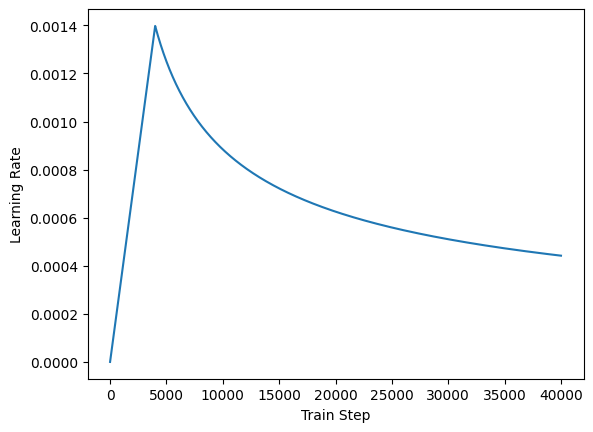

In [45]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Tiếp theo, bạn thiết lập phần lỗ. Vì các chuỗi mục tiêu được đệm nên điều quan trọng là phải áp dụng mặt nạ đệm khi tính toán tổn thất.

Bạn sẽ sử dụng hàm mất entropy chéo phân loại thưa thớt (`tf.keras.losses.SparseCategoricalCrossentropy`) và đặt tham số `from_logits` thành Sai vì Transformer không xuất ra nhật ký thô vì lớp cuối cùng có kích hoạt softmax:

In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


train_loss = tf.keras.metrics.Mean(name='train_loss')

# Here you will store the losses, so you can later plot them
losses = []

Bây giờ bạn có thể xác định chức năng đào tạo tùy chỉnh của mình. Nếu bạn không rành về tensorflow, bạn có thể hiểu hàm này như một giải pháp thay thế cho việc sử dụng `model.compile()` và `model.fit()`, nhưng có thêm tính linh hoạt.

In [47]:
@tf.function
def train_step(model, inp, tar):
    """
    One training step for the transformer
    Arguments:
        inp (tf.Tensor): Input data to summarize
        tar (tf.Tensor): Target (summary)
    Returns:
        None
    """
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # Create masks
    enc_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = create_padding_mask(inp) # Notice that both encoder and decoder padding masks are equal

    with tf.GradientTape() as tape:
        predictions, _ = model(
            inp,
            tar_inp, 
            True, 
            enc_padding_mask, 
            look_ahead_mask, 
            dec_padding_mask
        )
        loss = masked_loss(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

Bây giờ bạn đã sẵn sàng để đào tạo mô hình. Nhưng trước khi bắt đầu đào tạo, bạn cũng có thể xác định thêm một bộ hàm để thực hiện suy luận. Vì bạn đang sử dụng vòng lặp đào tạo tùy chỉnh nên bạn có thể làm bất cứ điều gì bạn muốn giữa các bước đào tạo. Và chẳng phải sẽ rất thú vị khi xem sau mỗi kỷ nguyên một số ví dụ về cách hoạt động của mô hình sao?

<a name='11'></a>
##11 - Tóm tắt

Điều cuối cùng bạn sẽ thực hiện là suy luận. Với điều này, bạn sẽ có thể tạo ra các bản tóm tắt thực tế của các tài liệu. Bạn sẽ sử dụng một phương pháp đơn giản gọi là giải mã tham lam, có nghĩa là bạn sẽ dự đoán từng từ một và thêm nó vào đầu ra. Bạn sẽ bắt đầu với mã thông báo `[SOS]` và lặp lại suy luận từng từ cho đến khi mô hình trả về cho bạn mã thông báo `[EOS]` hoặc cho đến khi bạn đạt đến độ dài tối đa của câu (bạn cần thêm giới hạn này, nếu không thì mô hình được đào tạo kém có thể cung cấp cho bạn vô số câu mà không bao giờ tạo ra mã thông báo `[EOS]`.

<a name='ex-5'></a>
### Bài tập 5 - next_word
Viết hàm trợ giúp dự đoán từ tiếp theo để bạn có thể dùng nó để viết cả câu. Gợi ý: điều này rất giống với những gì xảy ra trong train_step, nhưng bạn phải đặt quá trình huấn luyện mô hình thành Sai.

In [48]:
# GRADED FUNCTION: next_word
def next_word(model, encoder_input, output):
    """
    Helper function for summarization that uses the model to predict just the next word.
    Arguments:
        encoder_input (tf.Tensor): Input data to summarize
        output (tf.Tensor): (incomplete) target (summary)
    Returns:
        predicted_id (tf.Tensor): The id of the predicted word
    """
    ### START CODE HERE ###
    # Create a padding mask for the input (encoder)
    enc_padding_mask = create_padding_mask(encoder_input)
    # Create a look-ahead mask for the output
    look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
    # Create a padding mask for the input (decoder)
    dec_padding_mask = create_padding_mask(encoder_input)

    # Run the prediction of the next word with the transformer model
    predictions, attention_weights = model(
        encoder_input,
        output,
        False,
        enc_padding_mask,
        look_ahead_mask,
        dec_padding_mask
    )
    ### END CODE HERE ###

    predictions = predictions[: ,-1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    return predicted_id

Kiểm tra xem chức năng của bạn có hoạt động không.

In [49]:
# Take a random sentence as an input
input_document = tokenizer.texts_to_sequences(["a random sentence"])
input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
encoder_input = tf.expand_dims(input_document[0], 0)

# Take the start of sentence token as the only token in the output to predict the next word
output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)

# predict the next word with your function
predicted_token = next_word(transformer, encoder_input, output)
print(f"Predicted token: {predicted_token}")

predicted_word = tokenizer.sequences_to_texts(predicted_token.numpy())[0]
print(f"Predicted word: {predicted_word}")

Predicted token: [[14859]]
Predicted word: masses


##### __Kết quả mong đợi__

```
Predicted token: [[14859]]
Predicted word: masses
```

In [50]:
# UNIT TEST
w2_unittest.test_next_word(next_word, transformer, encoder_input, output)

 All tests passed!


In [51]:
def summarize(model, input_document):
    """
    A function for summarization using the transformer model
    Arguments:
        input_document (tf.Tensor): Input data to summarize
    Returns:
        _ (str): The summary of the input_document
    """    
    input_document = tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
    encoder_input = tf.expand_dims(input_document[0], 0)
    
    output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)
    
    for i in range(decoder_maxlen):
        predicted_id = next_word(model, encoder_input, output)
        output = tf.concat([output, predicted_id], axis=-1)
        
        if predicted_id == tokenizer.word_index["[EOS]"]:
            break

    return tokenizer.sequences_to_texts(output.numpy())[0]  # since there is just one translated document

Bây giờ bạn đã có thể tóm tắt một câu! Nhưng hãy cẩn thận, vì mô hình chưa được đào tạo nên nó sẽ chỉ tạo ra những kết quả vô nghĩa.

In [52]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
summarize(transformer, document[training_set_example])

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


"[SOS] masses kindergarten concept kindergarten concept bloomer wilingness sux sam kindergarten lisabeth kindergarten sawyer's sawyer's masses concept bloomer lisabeth bloomer wilingness 80000 bt hotsummer hoax hoax kieslowski wilingness 80000 dont't elis' 🐶❤️👍 cots saaaad evelynn inexperienced suji zubac forthcoming callum farmers extraordinary callum kindergarten worthy extraordinary readable 🐶❤️👍 thinkgn 🐶❤️👍 cots"

<a name='12'></a>
#12 - Huấn luyện người mẫu

Bây giờ cuối cùng bạn có thể huấn luyện mô hình. Dưới đây là một vòng lặp sẽ huấn luyện mô hình của bạn trong 20 kỷ nguyên. lưu ý rằng sẽ mất khoảng 30 giây mỗi kỷ nguyên (ngoại trừ một số kỷ nguyên đầu tiên có thể mất vài phút mỗi kỷ nguyên).

Lưu ý rằng sau mỗi giai đoạn, bạn thực hiện tóm tắt một trong các câu trong bộ kiểm tra và in nó ra để bạn có thể thấy mô hình của mình đang được cải thiện như thế nào.

In [ ]:
# Take an example from the test set, to monitor it during training
test_example = 0
true_summary = summary_test[test_example]
true_document = document_test[test_example]

# Define the number of epochs
epochs = 20

# Training loop
for epoch in range(epochs):
    
    start = time.time()
    train_loss.reset_states()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        train_step(transformer, inp, tar)
    
    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())
    
    print (f'Time taken for one epoch: {time.time() - start} sec')
    print('Example summarization on the test set:')
    print('  True summarization:')
    print(f'    {true_summary}')
    print('  Predicted summarization:')
    print(f'    {summarize(transformer, true_document)}\n')

Vẽ hàm mất mát.

In [ ]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

<a name='13'></a>
#13 – Tóm tắt một số câu!

Dưới đây bạn có thể xem ví dụ về tóm tắt một câu từ tập huấn luyện và một câu từ tập kiểm tra. Hãy xem bạn có nhận thấy điều gì thú vị ở họ không nhé!

In [ ]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
print(summarize(transformer, document[training_set_example]))

In [ ]:
test_set_example = 3

# Check a summary of a document from the test set
print('Test set example:')
print(document_test[test_set_example])
print('\nHuman written summary:')
print(summary_test[test_set_example])
print('\nModel written summary:')
print(summarize(transformer, document_test[test_set_example]))

Nếu bạn xem xét kỹ lưỡng kết quả đầu ra của mô hình, bạn có thể nhận thấy một số điều:
- Trong tập huấn luyện, đầu ra của mô hình (gần như) giống với đầu ra thực (đã có sau 20 kỷ nguyên và thậm chí còn hơn thế nữa với nhiều kỷ nguyên hơn). Điều này có thể là do tập huấn luyện tương đối nhỏ và mô hình tương đối lớn và do đó đã học thuộc lòng các câu trong tập huấn luyện (trang bị quá mức).
- Mặc dù hiệu suất trên tập huấn luyện trông rất tuyệt vời nhưng lại không tốt lắm trên tập kiểm tra. Mô hình phù hợp nhưng không khái quát hóa được. Một lần nữa, một ứng cử viên dễ bị đổ lỗi là tập huấn luyện nhỏ và mô hình tương đối lớn, nhưng có thể có nhiều yếu tố khác.
- Xem ví dụ tập kiểm tra 3 và phần tóm tắt của nó. Bạn có thể tóm tắt nó giống như cách nó được viết ở đây không? Đôi khi dữ liệu có thể mơ hồ. Và việc đào tạo **mô hình của bạn chỉ có thể tốt khi dữ liệu của bạn**.

Ở đây bạn chỉ sử dụng một tập dữ liệu nhỏ để cho thấy rằng có thể học được điều gì đó trong một khoảng thời gian hợp lý trong một môi trường tương đối nhỏ. Nói chung, các máy biến áp lớn được đào tạo về nhiều nhiệm vụ và trên lượng dữ liệu rất lớn để đạt được hiệu suất vượt trội. Bạn sẽ tìm hiểu thêm về điều này trong phần còn lại của khóa học này.

**Chúc mừng bạn đã hoàn thành bài tập tuần này!** Bạn đã làm được rất nhiều việc và bây giờ bạn nên hiểu rõ hơn về Máy biến áp và các khối xây dựng của chúng (bộ mã hóa và bộ giải mã) cũng như cách sử dụng chúng để tóm tắt văn bản. Và hãy nhớ: bạn không cần thay đổi nhiều để sử dụng cùng một mô hình cho người dịch, chỉ cần thay đổi tập dữ liệu và nó sẽ hoạt động!

**Cố lên!**